# <span style='color:#2e7d32'>**Introduction**</span>

In this notebook we will analyze the **Online Retail II** dataset, a real transactional dataset containing e-commerce sales for a UK-based online retailer. The data includes detailed records of customer purchases such as invoice numbers, product codes, descriptions, quantities, unit prices, transaction dates, and customer identifiers.

The goal of this analysis is to transform the raw transactional data into meaningful insights through:

* **Data Cleaning:** correcting data types, handling missing values, fixing inconsistent entries, and preparing the dataset for analysis.
* **Feature Engineering:** creating new variables to enhance analytical depth.
* **Exploratory Data Analysis:** examining distributions, identifying patterns, and exploring relationships between variables to understand customer behavior and sales dynamics.
* **Visualization:** using Matplotlib and Seaborn to produce clear and interpretable charts that highlight key trends and findings.

More information about the dataset is available at the [**Online Retail II**](https://archive.ics.uci.edu/dataset/502/online+retail+ii) page.


# <span style='color:#2e7d32'>**Loading the data**</span>

In [1]:
# Importing libraries 

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(14,8)})

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the data

data = pd.read_excel('online_retail_II.xlsx')

In [3]:
df = data.copy()
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


# <span style='color:#2e7d32'>**Data Cleaning**</span>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


### <span style='color:#90EE90'>**Rename columns**</span>

In [5]:
# Unified Name Styles
def to_snake(name):
    name = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name)
    name = re.sub(r'[ .]+', '_', name)
    name = re.sub(r'_+', '_', name)
    return name.lower()

df.columns = [to_snake(col) for col in df.columns]
df.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'price', 'customer_id', 'country'],
      dtype='object')

### <span style='color:#90EE90'>**Duplicated values**</span>

In [6]:
# Checking for duplicates

df.duplicated().sum()

np.int64(6865)

In [7]:
# Removing duplicated data

df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

### <span style='color:#90EE90'>**Missing values & Imputation**</span>

In [8]:
# null values

df.isnull().sum()

invoice              0
stock_code           0
description       2928
quantity             0
invoice_date         0
price                0
customer_id     107833
country              0
dtype: int64

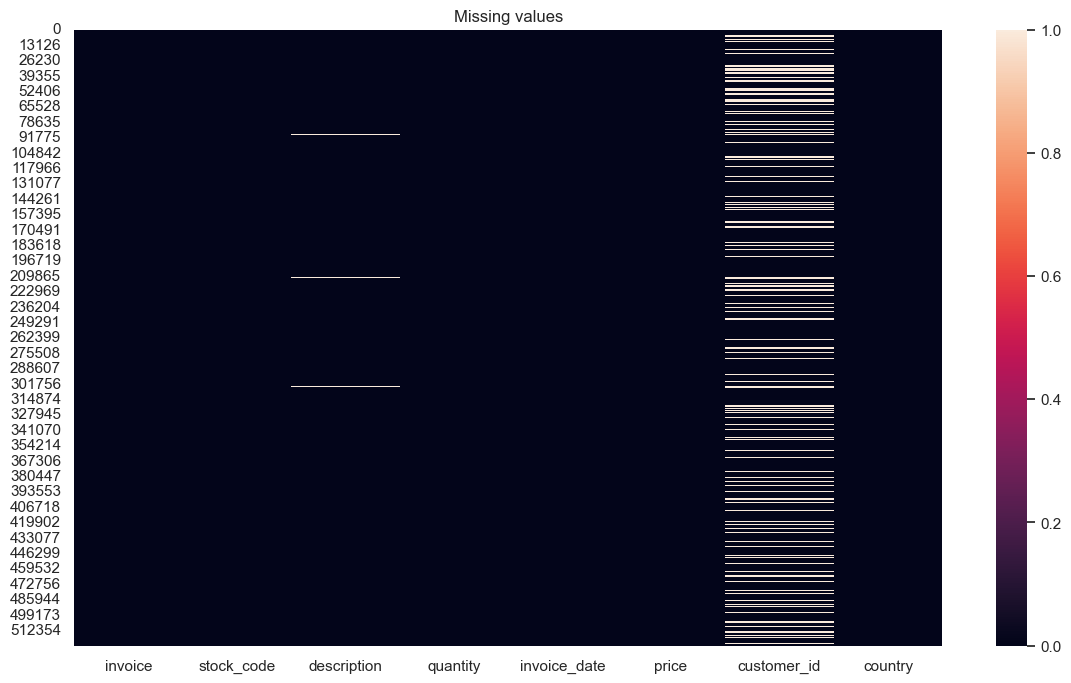

In [9]:
sns.heatmap(df.isnull())
plt.title('Missing values')
plt.show()

In [10]:
# Manual imputation for the description column (most common)

print(f"Before: {df.description.isna().sum()}")
df.loc[:, 'description'] = df.groupby('stock_code')['description'].transform(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
)

df.loc[:, 'description'] = df['description'].fillna('Unknown')

Before: 2928


In [11]:
# Removing '.0' from floats and filling null values

df['customer_id'] = df['customer_id'].astype(str).str.replace('\.0$', '', regex=True)

df.loc[:, 'customer_id'] = df['customer_id'].fillna('Unknown')

df.isna().sum().sum()

np.int64(0)

In [12]:
# These rows will affect the results (bad dept), so we will remove them

print(df[df['invoice'].str.contains('A', na=False,case=False)])

df_bad_depts = df[df['invoice'].str.contains('A', na=False,case=False)]
df = df[~df['invoice'].str.contains('A', na=False, case=False)]

        invoice stock_code      description  quantity        invoice_date  \
179403  A506401          B  Adjust bad debt         1 2010-04-29 13:36:00   
276274  A516228          B  Adjust bad debt         1 2010-07-19 11:24:00   
403472  A528059          B  Adjust bad debt         1 2010-10-20 12:04:00   

           price customer_id         country  
179403 -53594.36         nan  United Kingdom  
276274 -44031.79         nan  United Kingdom  
403472 -38925.87         nan  United Kingdom  


### <span style='color:#90EE90'>**Data types**</span>

In [13]:
# Cheking data types 
df.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
price                  float64
customer_id             object
country                 object
dtype: object

# <span style='color:#2e7d32'>**Feature Engineering**</span>

In [14]:
# total_spend = quantity × price
df.loc[:,'total_spend'] = df['quantity'] * df['price']

# Detecting canceled orders
df.loc[:,'canceled'] = df['invoice'].str.contains('C', na=False,case=False).astype(int)

# Positive values for quantity
df.loc[:,'abs_quantity'] = df['quantity'].abs()

# Dates extracted from invoice_date
df['week_days'] = df['invoice_date'].dt.day_name()
df['month'] = df['invoice_date'].dt.month
df['year'] = df['invoice_date'].dt.year
df['hour_of_day'] = df['invoice_date'].dt.hour
df['quarter'] = df['invoice_date'].dt.quarter
df['yearmonth'] = df['invoice_date'].dt.to_period('M').astype(str)
df['yearWeek'] = df['invoice_date'].dt.strftime('%Y-W%U')

# <span style='color:#2e7d32'>**Exploratory Data Analysis**</span>

In [15]:
# Unique values per column

df.nunique()

invoice         28813
stock_code       4631
description      4107
quantity          825
invoice_date    25294
price            1603
customer_id      4384
country            40
total_spend      5690
canceled            2
abs_quantity      545
week_days           7
month              12
year                2
hour_of_day        15
quarter             4
yearmonth          13
yearWeek           53
dtype: int64

All columns contain multiple distinct values, so there are no columns with only a single unique value.

In [16]:
# What are the lowest, highest, and average prices of items?, quantities in an order?

df[['quantity','price']].describe()

,quantity,price
count,518593.000000,518593.000000
mean,10.438207,4.979516
std,108.126903,97.128954
min,-9600.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,10.000000,4.210000
max,19152.000000,25111.090000


The maximum and minimum values are extremely large, indicating the presence of outliers in both columns.

In [17]:
# How much revenue is lost due to returns?

lost_revenue = df[(df['canceled'] == True) & (df['quantity'] < 0)]['total_spend'].sum()
print(f"Revenue lost due to returns: {lost_revenue:.3f}")

Revenue lost due to returns: -629808.650


In [18]:
# What is the total sales amount (revenue)?

revenue = df[(df['canceled'] == False) & (df['quantity'] > 0)]['total_spend'].sum()
print(f"Revenue: {revenue:.3f}")

Revenue: 10271762.664


In [19]:
#  How many items were sold in total?

tems_sold = df[(df['canceled'] == False) & (df['quantity'] > 0)]['abs_quantity'].sum()
print(f"Items sold: {tems_sold:.3f}")

Items sold: 5992597.000


In [20]:
# How many unique customers are in the data?

n_customers = df['customer_id'].nunique()
print(f"Number of customers: {n_customers:.3f}")

Number of customers: 4384.000


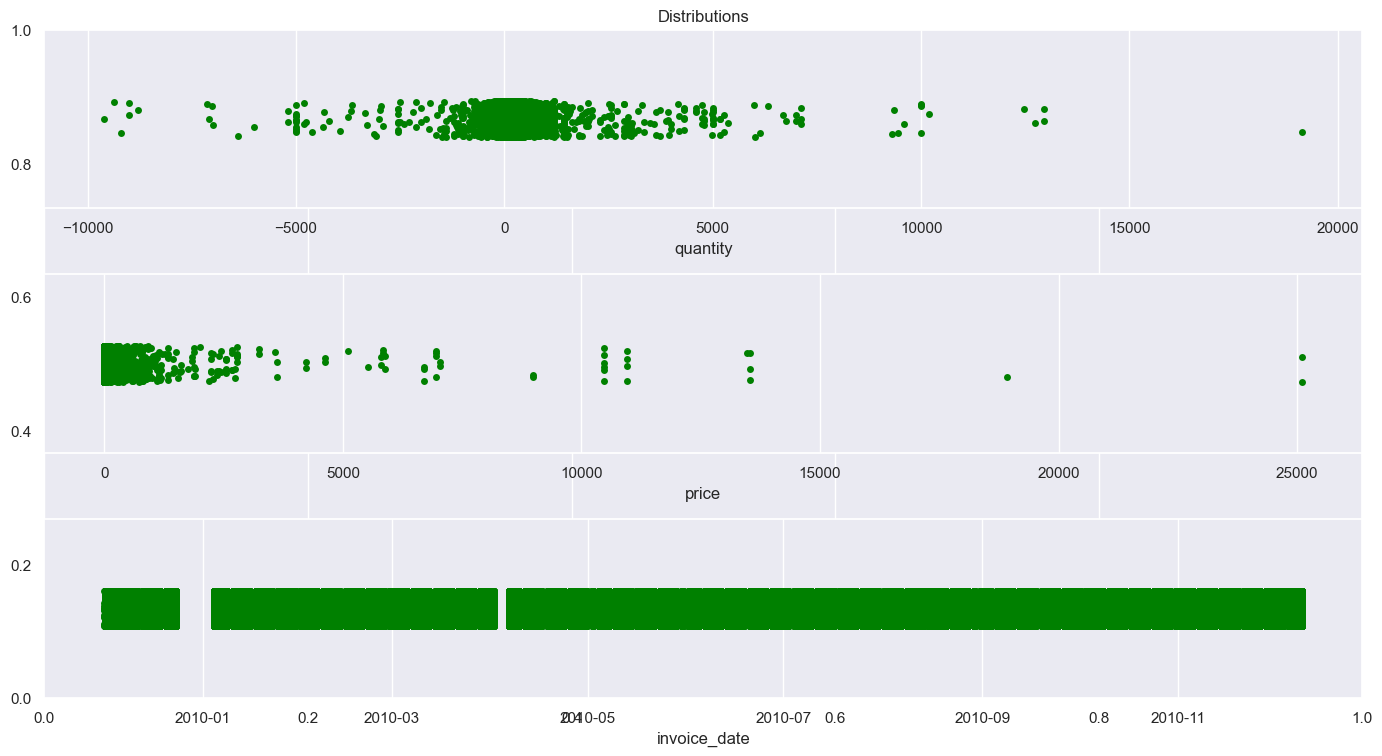

In [21]:
# Distribution of important columns
plt.title('Distributions')

plt.subplot(3, 1, 1)  
sns.stripplot(x=df.quantity, color='green')
plt.subplot(3, 1, 2) 
sns.stripplot(x=df.price, color='green')
plt.subplot(3, 1, 3)
sns.stripplot(x=df.invoice_date, color='green')

plt.tight_layout()  
plt.show()

There are outliers in both the `Quantity` and `Price` columns. Removing them requires first understanding the business context and the methodologies used.

The `Invoice Date` column contains some missing or inconsistent values that need to be addressed.

For now, we will keep these outliers and missing dates, as they may represent valid business cases and require further context to handle appropriately.

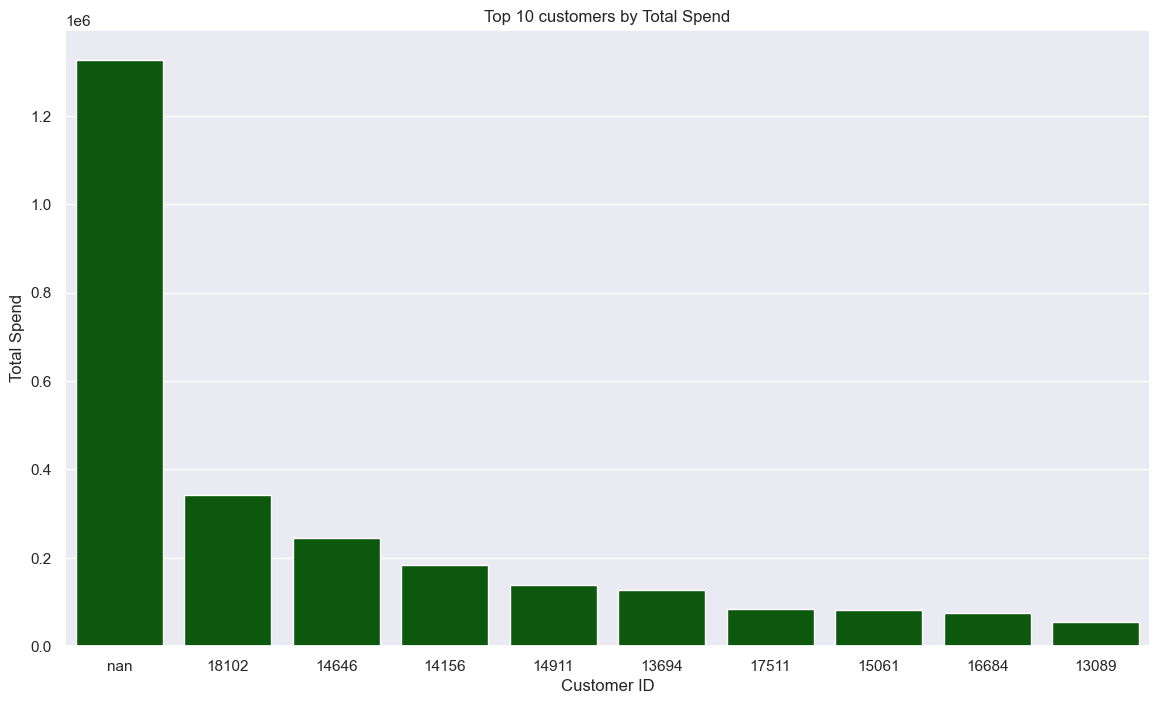

In [22]:
# top 10 customers by total spend

top_total_spend = df[df['customer_id']!='Unknown'].groupby('customer_id')['total_spend'].sum()\
    .sort_values(ascending=False).head(10).reset_index()
sns.barplot(top_total_spend,x='customer_id',y='total_spend',order=top_total_spend['customer_id'],
            color='darkgreen'
)
plt.title('Top 10 customers by Total Spend')
plt.xlabel('Customer ID')
plt.ylabel('Total Spend')
plt.show();

There are many unknown customers, but using the available data, we can identify the top customers as `18102`, `14646`, and `14156`.

In [23]:
# average basket size and basket value per customer

# Average quantity per invoice per customer
avg_basketsize = df.groupby('invoice')['abs_quantity'].mean().rename('avg_basketsize').round(2)
if 'avg_basketsize' not in df.columns:
    df = df.merge(avg_basketsize, on='invoice', how='left')

# Average spend per invoice per customer
avg_basketvalue = df.groupby('invoice')['total_spend'].mean().rename('avg_basketvalue').round(2)
if 'avg_basketvalue' not in df.columns:
    df = df.merge(avg_basketvalue, on='invoice', how='left')

df0 = df.groupby('customer_id').agg({
    'avg_basketsize': 'mean',
    'avg_basketvalue': 'mean'
}).round(2)

df0

,avg_basketsize,avg_basketvalue
customer_id,,
12346,1.93,-1.15
12347,11.66,18.64
12348,18.65,11.11
12349,9.33,24.74
12351,12.43,14.33
...,...,...
18284,17.07,15.06
18285,12.08,35.58
18286,8.92,16.98


In [24]:
# removing 1% of outliers to read the plot

upper_size = df0['avg_basketsize'].quantile(0.99)

lower_value = df0['avg_basketvalue'].quantile(0.005)
upper_value = df0['avg_basketvalue'].quantile(0.995)

# Keep only rows inside the middle 99% for both columns
df0_filtered = df0[
    (df0['avg_basketsize'] <= upper_size) &
    (df0['avg_basketvalue'] >= lower_value) & 
    (df0['avg_basketvalue'] <= upper_value)
]

df0_filtered

,avg_basketsize,avg_basketvalue
customer_id,,
12346,1.93,-1.15
12347,11.66,18.64
12348,18.65,11.11
12349,9.33,24.74
12351,12.43,14.33
...,...,...
18284,17.07,15.06
18285,12.08,35.58
18286,8.92,16.98


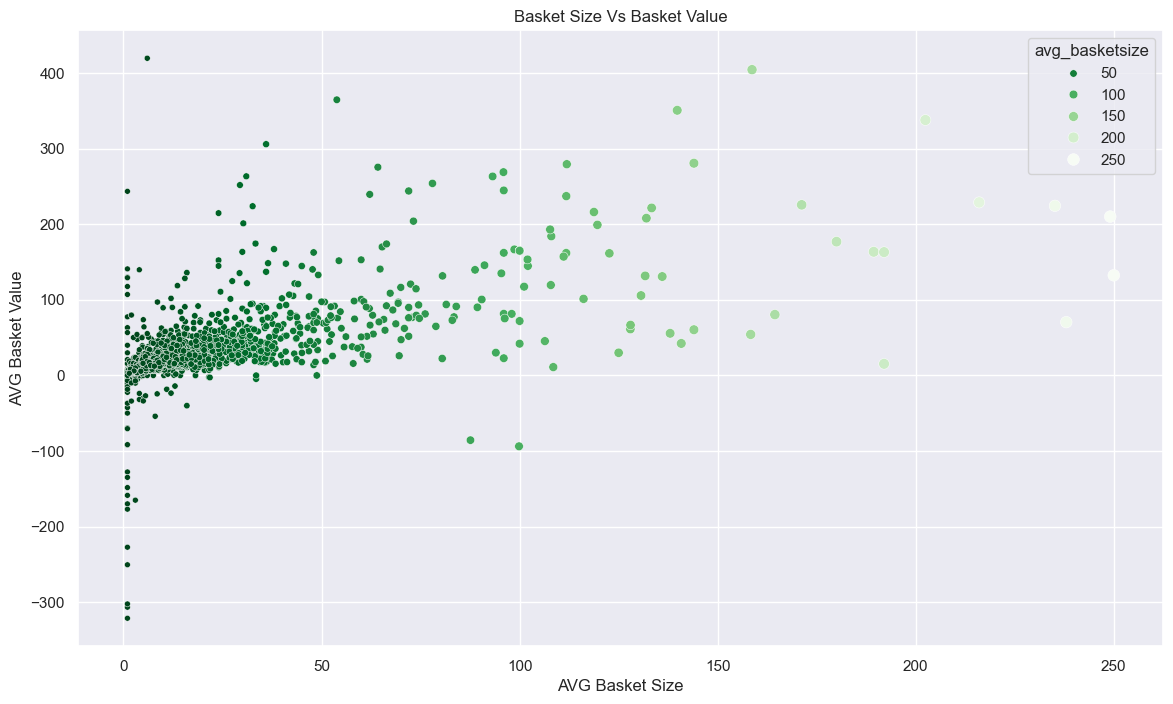

In [25]:
sns.scatterplot(data=df0_filtered, x='avg_basketsize', y='avg_basketvalue',
                hue='avg_basketsize', palette='Greens_r',size='avg_basketsize')
plt.title('Basket Size Vs Basket Value')
plt.xlabel('AVG Basket Size')
plt.ylabel('AVG Basket Value')
plt.show();

There is a positive trend, as `avg_basketsize` increases, `avg_basketvalue` also tends to increase. This is expected, as customers who buy more items typically spend more per invoice.

A few points have very high basket sizes or values, which may represent top customers or unusual purchases and are worth further investigation.

The scatter plot shows that most customers purchase a small number of items per invoice and spend relatively little. The majority of basket sizes fall between 0 and 40, while basket values are mostly between 0 and 60.



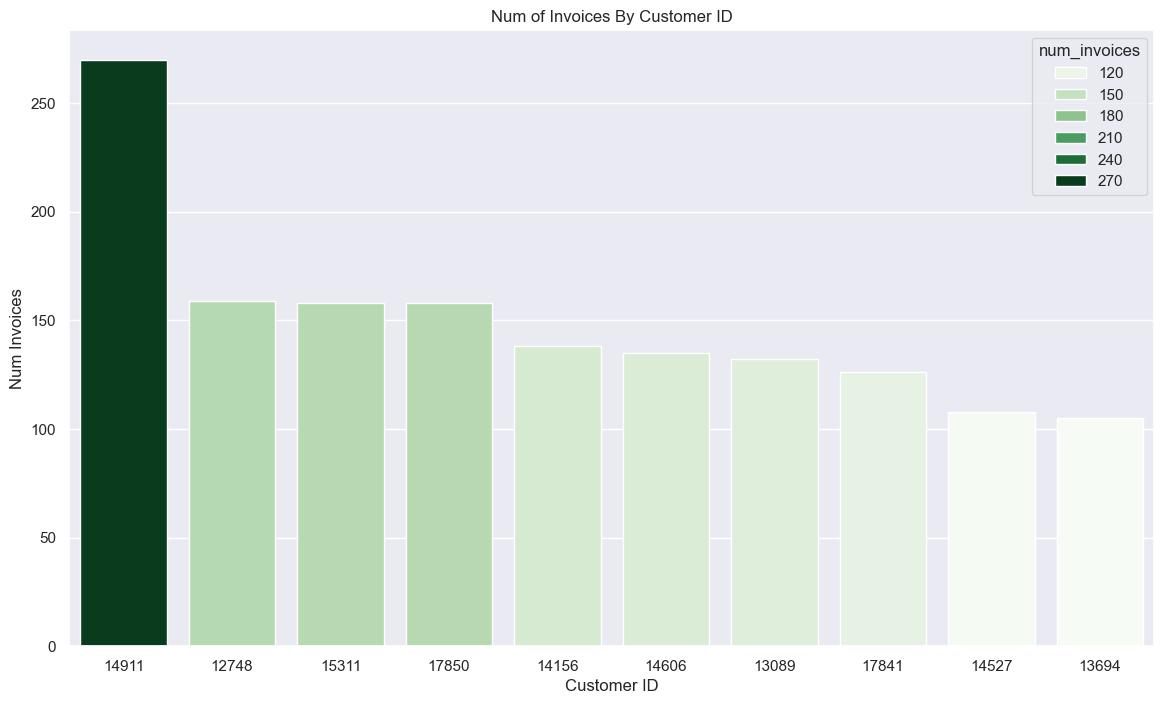

In [26]:
# Which customers placed the most invoices?

num_invoices = df.groupby('customer_id')['invoice'].nunique().rename('num_invoices')
# df = df.merge(num_invoices, on='customer_id', how='left')
df['num_invoices'] = df['customer_id'].map(num_invoices)

df0 = num_invoices.nlargest(11)[1::].reset_index()
sns.barplot(df0, x=df0.customer_id, y=df0.num_invoices,
            hue=df0.num_invoices, palette='Greens')
plt.title('Num of Invoices By Customer ID')
plt.xlabel('Customer ID')
plt.ylabel('Num Invoices')
plt.show();

Customer `14911` placed the highest number of invoices (over 260), while the rest are below 160. This creates a gap of more than 100 invoices compared with any other customer.

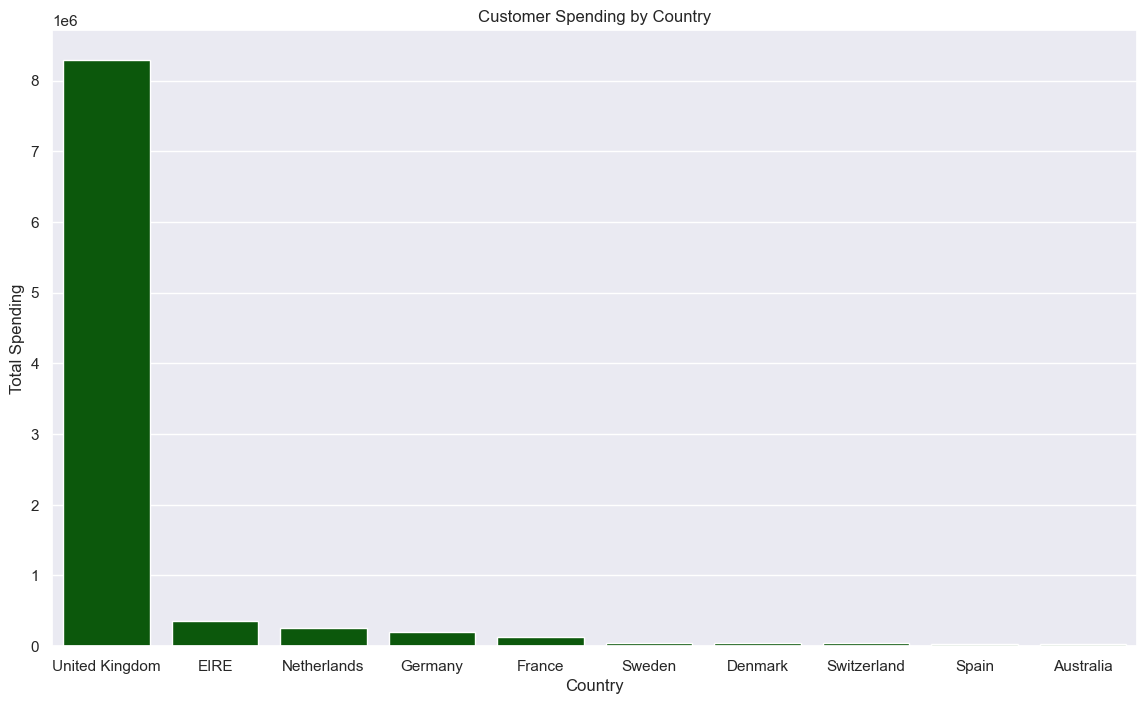

In [27]:
# How does customer spending differ by country?

sns.barplot(df.groupby('country')['total_spend'].sum().nlargest(10),
            color='darkgreen')

plt.title('Customer Spending by Country')
plt.xlabel('Country')
plt.ylabel('Total Spending')
plt.show();

`United kingdom` has the most customer spending rate with a great difffence from other countries.

Text(0, 0.5, 'Total Quantity')

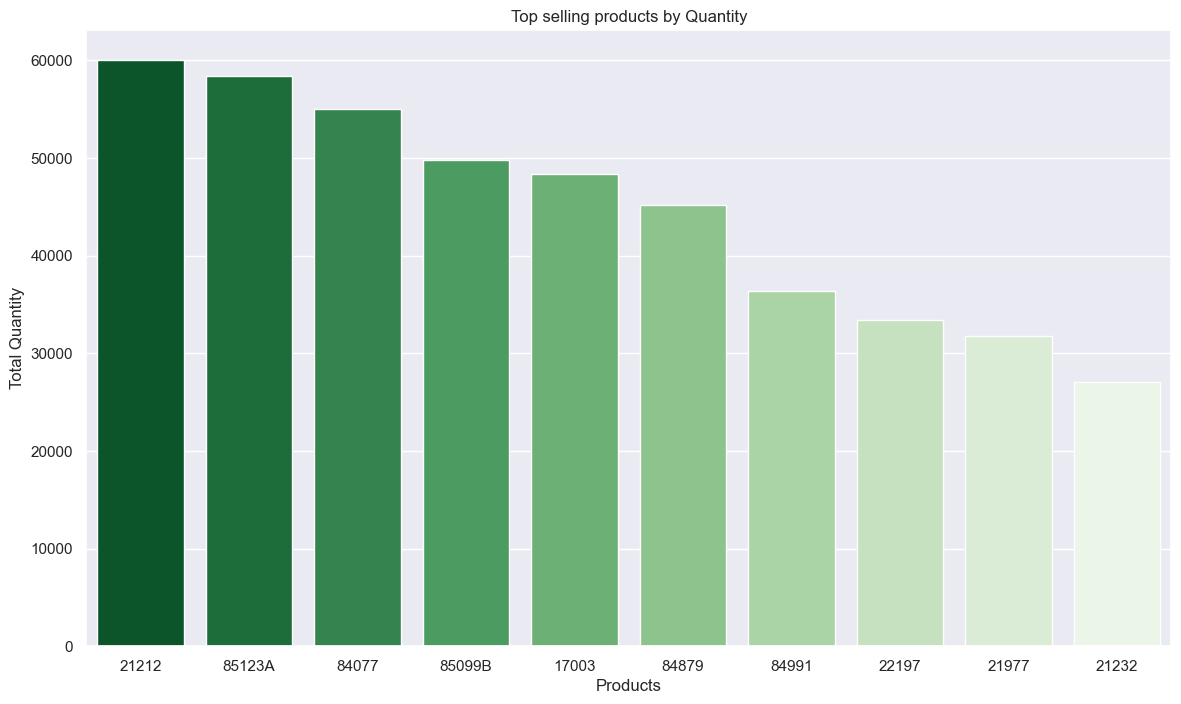

In [28]:
# What are the top 10 selling products by quantity?

df0 = df[(df['canceled'] == False) & (df['quantity'] > 0)]

df0 = df0.groupby('stock_code')['quantity'].sum().rename('ProductTotalquantity').nlargest(10)
sns.barplot(df0, palette='Greens_r')

plt.title('Top selling products by Quantity')
plt.xlabel('Products')
plt.ylabel('Total Quantity')

The top selling products are `21212`,`85123A`,`84077`.

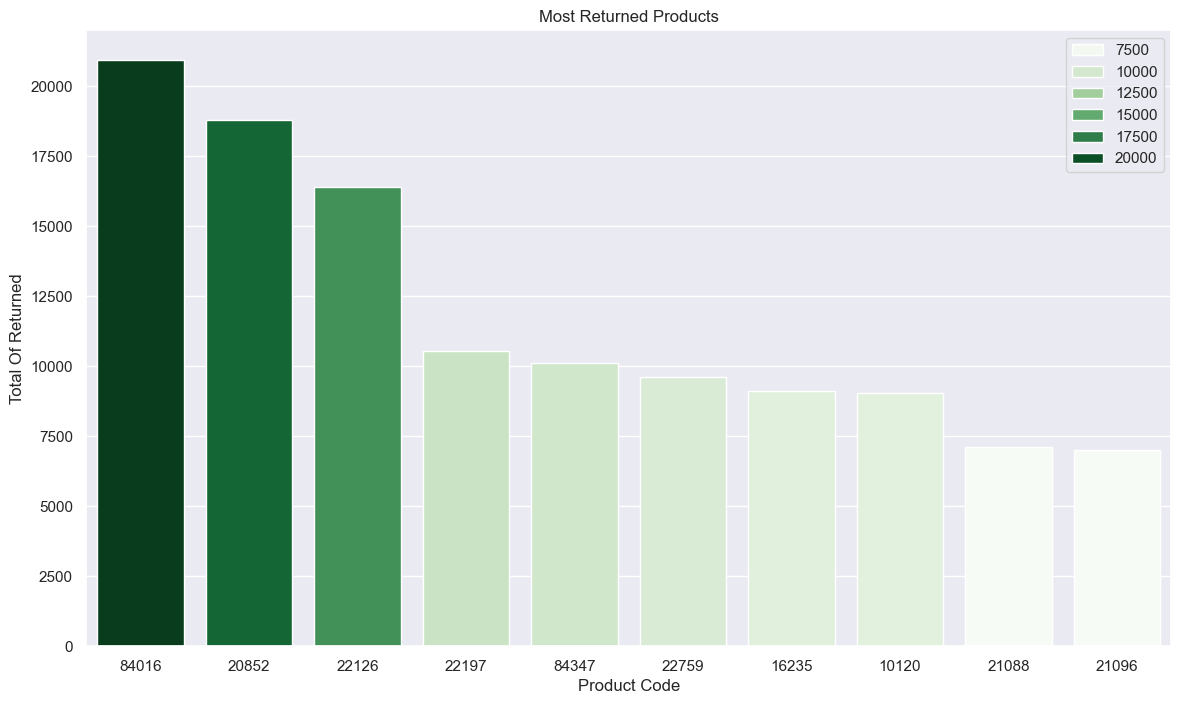

In [29]:
# What are the most returned products?

df0 = df[(df['quantity'] < 0)]

s = df0.groupby('stock_code')['abs_quantity'].sum().rename('returned').nlargest(10)

sns.barplot(x=s.index, y=s.values, hue=s.values, order=s.index,
            palette='Greens',)

plt.title('Most Returned Products')
plt.xlabel('Product Code')
plt.ylabel('Total Of Returned')
plt.show();

The most returned products are `84016`,`20852`,`22126`. with more than 5000 times difference.

In [30]:
# What is the average price of the top-selling products?

avg_price = df[df['quantity']>0].groupby('stock_code').agg(
    Avgprice=('price', 'mean'), 
    NumSells=('quantity', 'sum')
    )
# df = df.merge(avg_price, on='stock_code',how='left')
# df
avg_price.sort_values(by='NumSells',ascending=False)

,Avgprice,NumSells
stock_code,,
21212,0.670180,60076
85123A,3.047589,58387
84077,0.243050,55058
85099B,2.170180,49807
17003,0.239489,48384
...,...,...
84968d,25.490000,1
79070b,11.260000,1
79151B,0.420000,1


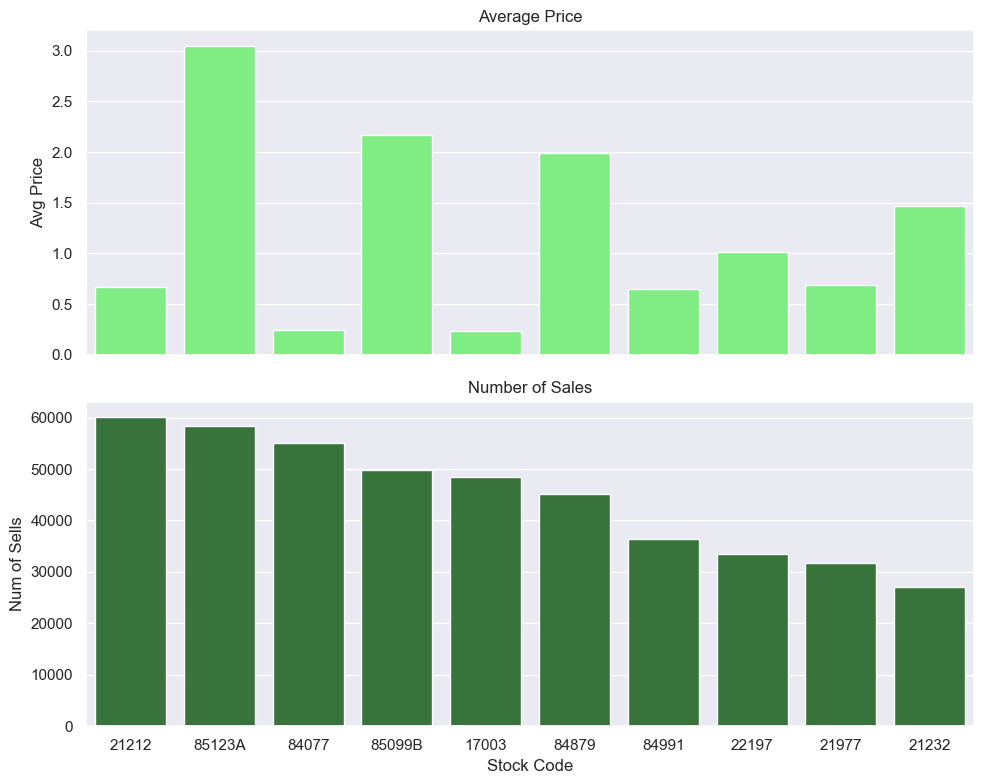

In [31]:
top10 = avg_price.nlargest(10, 'NumSells').reset_index()

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.barplot(
    data=top10, x='stock_code', y='Avgprice',    
    ax=axes[0], color="#6dff74"
)
axes[0].set_title("Average Price")
axes[0].set_ylabel('Avg Price')


sns.barplot(
    data=top10, x='stock_code', y='NumSells',
    ax=axes[1], color="#2e7d32"
)
axes[1].set_title("Number of Sales")
axes[1].set_xlabel('Stock Code')
axes[1].set_ylabel('Num of Sells')

plt.tight_layout()
plt.show()

Top-selling products are not necessarily high-priced or low priced. This is clear from items ranked 1, 3, and 5, which sell in large quantities despite having low prices.

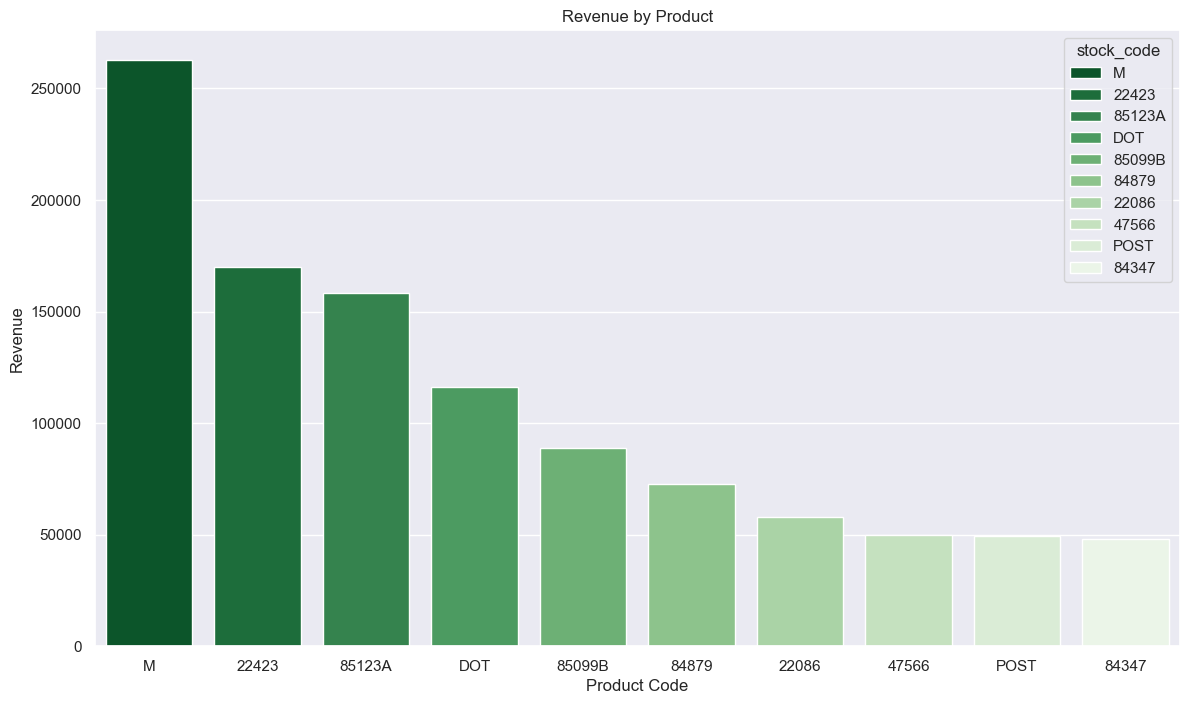

In [32]:
# Which products generate the most revenue?

revenue = df[df['quantity']>0].groupby('stock_code').agg(
    revenue=('total_spend', 'sum'), 
    )
df = df.merge(revenue,on='stock_code',how='left')

df0 = revenue.sort_values(by='revenue',ascending=False).head(10)

sns.barplot(data=df0, y='revenue',x='stock_code',
            hue='stock_code', palette='Greens_r'
)

plt.title('Revenue by Product')
plt.xlabel('Product Code')
plt.ylabel('Revenue')
plt.show();

These products generate the most revenue: `M`, `22423`, `85123A`.

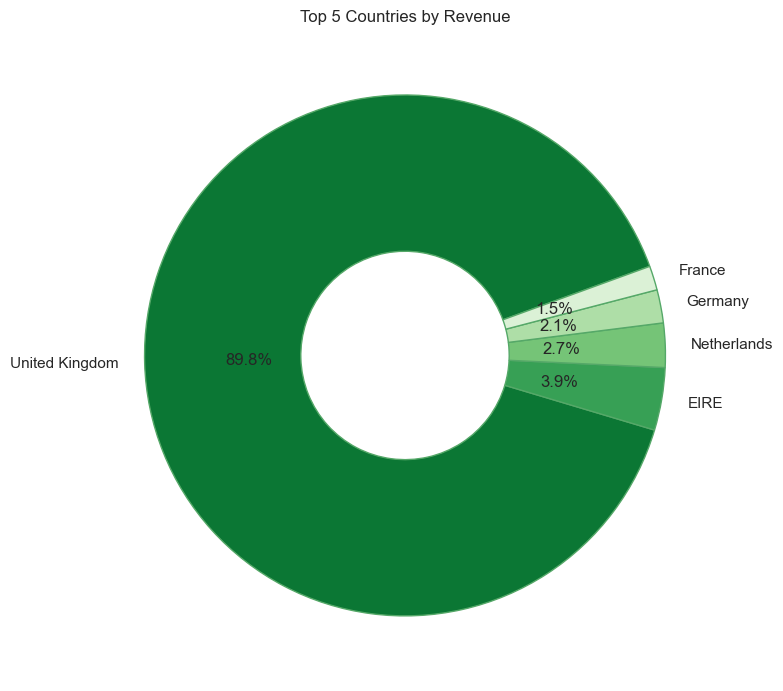

In [33]:
# What are the top 5 countries by total revenue?

revenue_by_country = df[df['quantity']>0].groupby('country').agg(
    revenue=('total_spend', 'sum'), 
    )

df0 = revenue_by_country.sort_values(by='revenue',ascending=False).head(5)
colors = sns.color_palette("Greens_r", n_colors=len(df0))

plt.figure(figsize=(8, 8))
plt.pie(df0['revenue'], labels=df0.index,
        autopct='%1.1f%%',
        colors=colors, startangle=20,
        wedgeprops={'width': 0.6, 'edgecolor': 'g'},
)
plt.title("Top 5 Countries by Revenue")
plt.tight_layout()
plt.show()

The top five countires by total revenue are: `United Kingdom`, `EIRE`, `Netherlands`, `Germany`, and `France`.

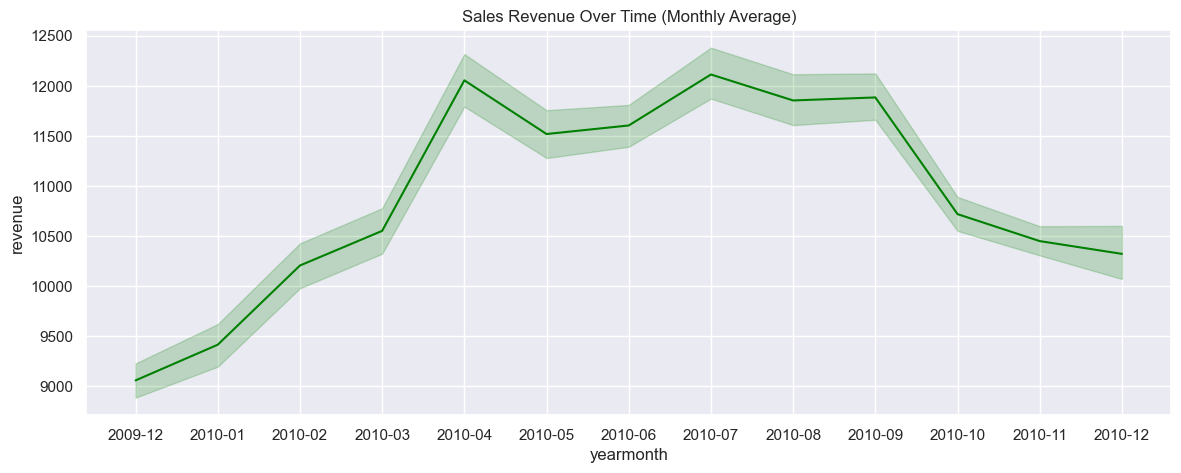

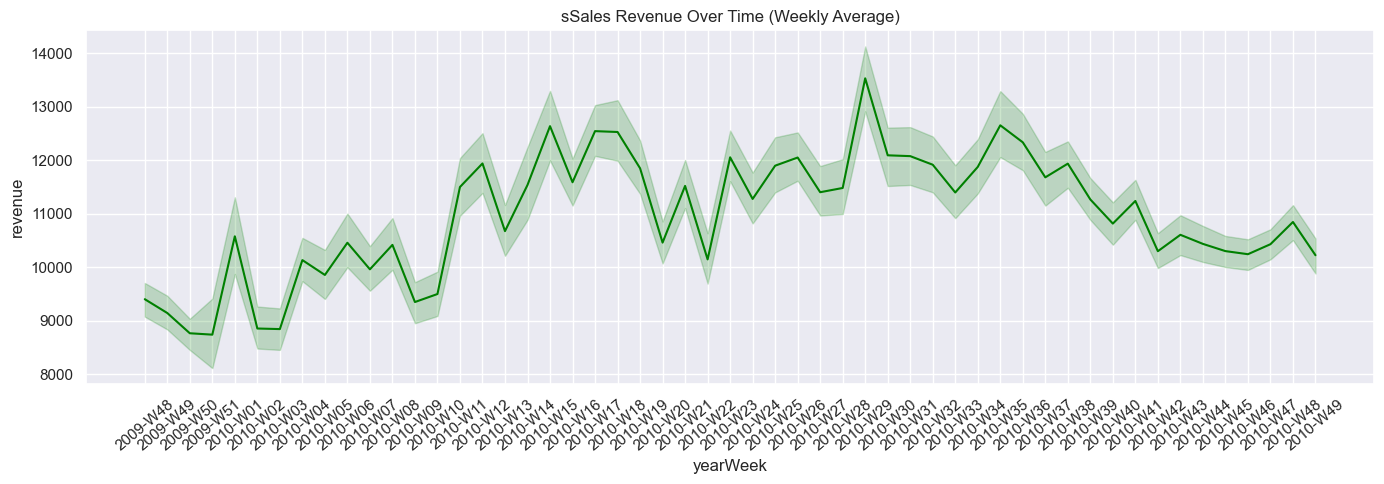

In [34]:
# How does sales revenue change over time (monthly, weekly)?

plt.figure(figsize=(14,5))
sns.lineplot(data=df[df['quantity'] > 0], x='yearmonth', y='revenue', color='green')
plt.title('Sales Revenue Over Time (Monthly Average)')
plt.show();

plt.figure(figsize=(14,5))
sns.lineplot(data=df[df['quantity'] > 0], x='yearWeek', y='revenue', color='green')
plt.xticks(rotation=40)
plt.title('sSales Revenue Over Time (Weekly Average)')
plt.tight_layout()
plt.show();

Both plots confirm that the middle of the year (Q2 and Q3) generates the highest revenue.

The weekly plot suggests that while the general trend is positive in the first half of the year (upward trend during the first half of the year and decline in the second half), the business experiences operational volatility week-to-week (holiday or promotion effects).

The shaded green areas (confidence intervals) suggest that revenue predictability remains relatively consistent throughout the year, though the range widens slightly during the high-revenue weeks in mid-2010.


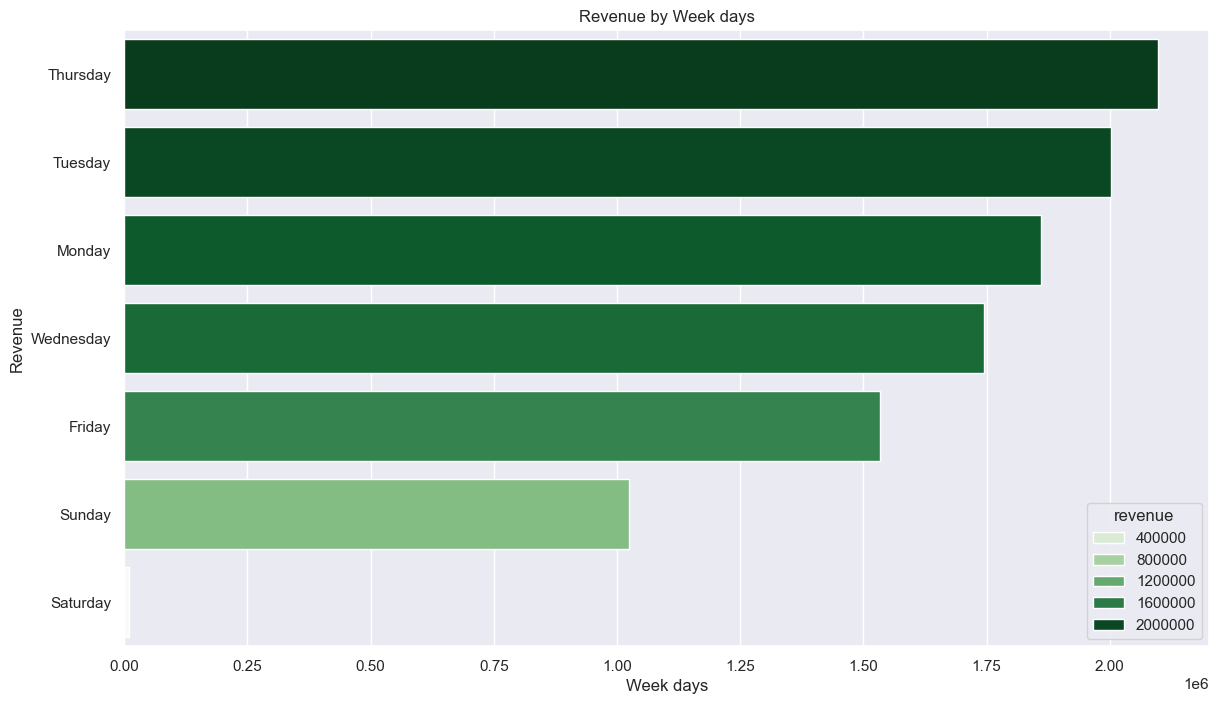

In [35]:
# What days of the week generate the most sales?

revenue_by_week_days = df[df['quantity']>0].groupby('week_days').agg(
    revenue=('total_spend', 'sum'), 
    )
ordered_days = revenue_by_week_days.sort_values('revenue', ascending=False).index

sns.barplot(data=revenue_by_week_days, y='week_days', x='revenue', 
            order=ordered_days, orient='h',
            hue='revenue', palette='Greens')

plt.title('Revenue by Week days')
plt.xlabel('Week days')
plt.ylabel('Revenue')
plt.show();

Days of the week that generates the most sales: `Thursday`,`Tuesday`, and `Monday` respectively.

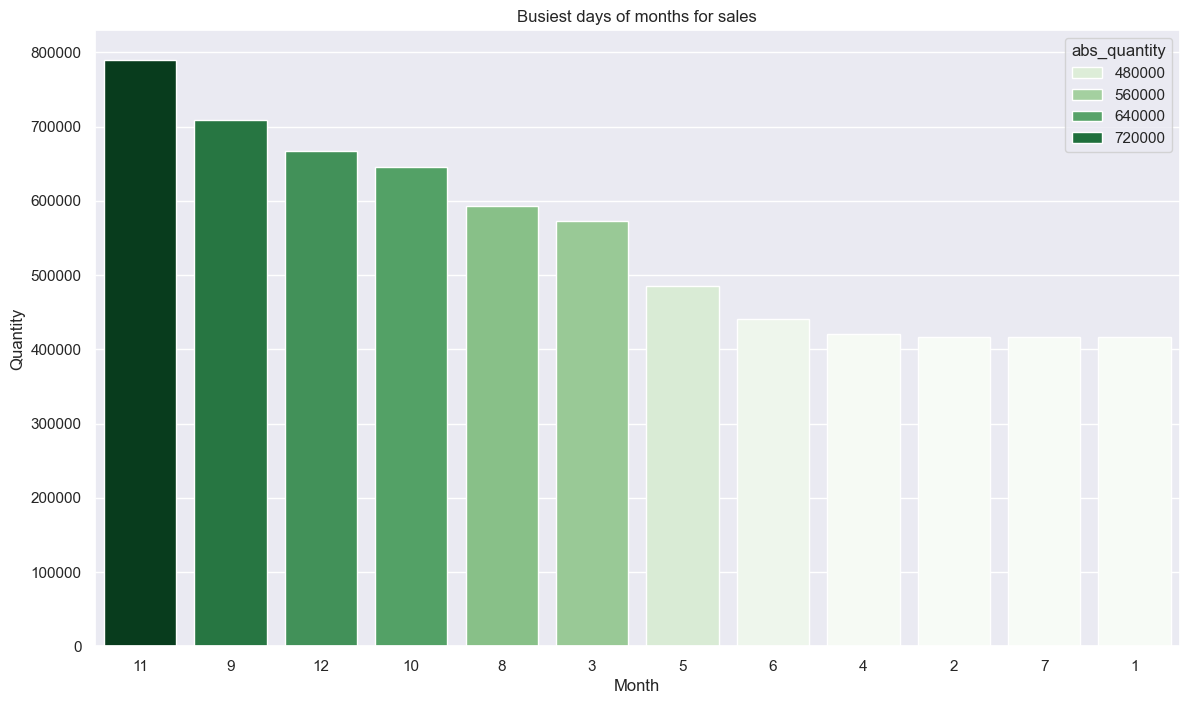

In [36]:
# What are the busiest days of months for sales?

busiest_months = df.groupby('month')[['abs_quantity']].sum().sort_values(by='abs_quantity',ascending=False)
ordered_months = busiest_months.sort_values(by='abs_quantity', ascending=False).index

sns.barplot(data=busiest_months, x='month', y='abs_quantity', hue='abs_quantity',
            order=ordered_months, palette='Greens')

plt.title('Busiest days of months for sales')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.show();


The busiest days of months for sales: `November`, `September`, `December`, and `October`.

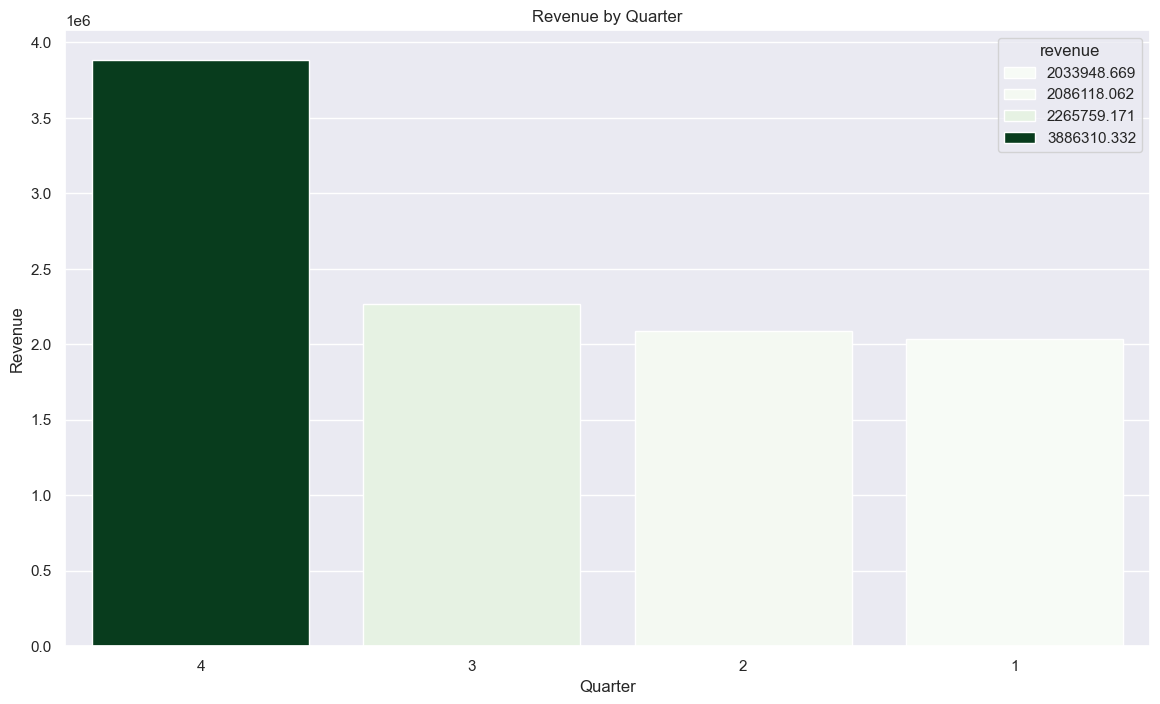

In [37]:
# What Quarter generate the most sales?

revenue_by_quarter = df[df['quantity']>0].groupby('quarter').agg(
    revenue=('total_spend', 'sum'), 
    )
ordered_days = revenue_by_quarter.sort_values('revenue', ascending=False).index

sns.barplot(data=revenue_by_quarter, x='quarter', y='revenue', 
            order=ordered_days, 
            hue='revenue', palette='Greens')

plt.title('Revenue by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.show();

The Quarter that generate the most sales: 4th.

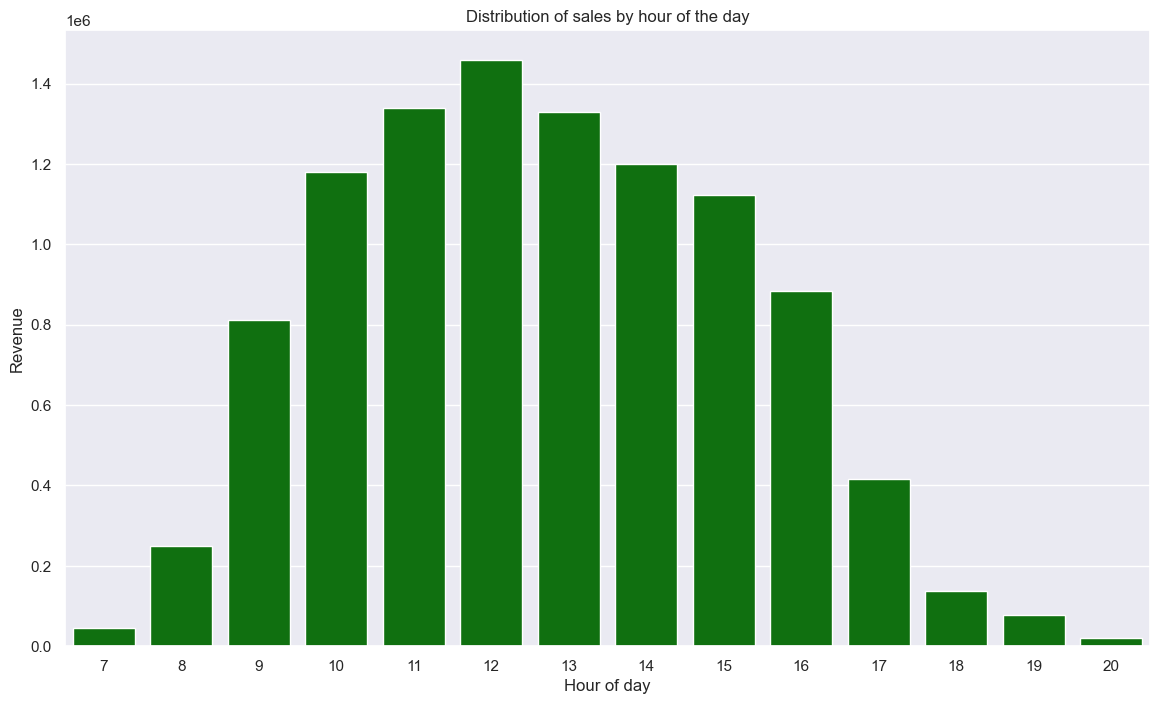

In [38]:
# What is the distribution of sales by hour of the day?

revenue_by_Hours = df[df['quantity']>0].groupby('hour_of_day').agg(
    revenue=('total_spend', 'sum'), 
    )

sns.barplot(data=revenue_by_Hours, x='hour_of_day', y='revenue',color='green')

plt.title('Distribution of sales by hour of the day')
plt.xlabel('Hour of day')
plt.ylabel('Revenue')
plt.show();

**Peak Performance:** Revenue peaks at `12:00 PM`, reaching the highest point on the chart (over 1.4 million).

**Core Business Hours:** The strongest sales window is between `10:00 AM` and `3:00 PM`.

There is a rapid increase in sales starting from `7:00 AM`, with significant jumps each hour until `10:00 AM`. After the midday peak, sales decline steadily. A sharp drop-off begins after 4:00 PM, tapering off to very low levels by `8:00 PM`.


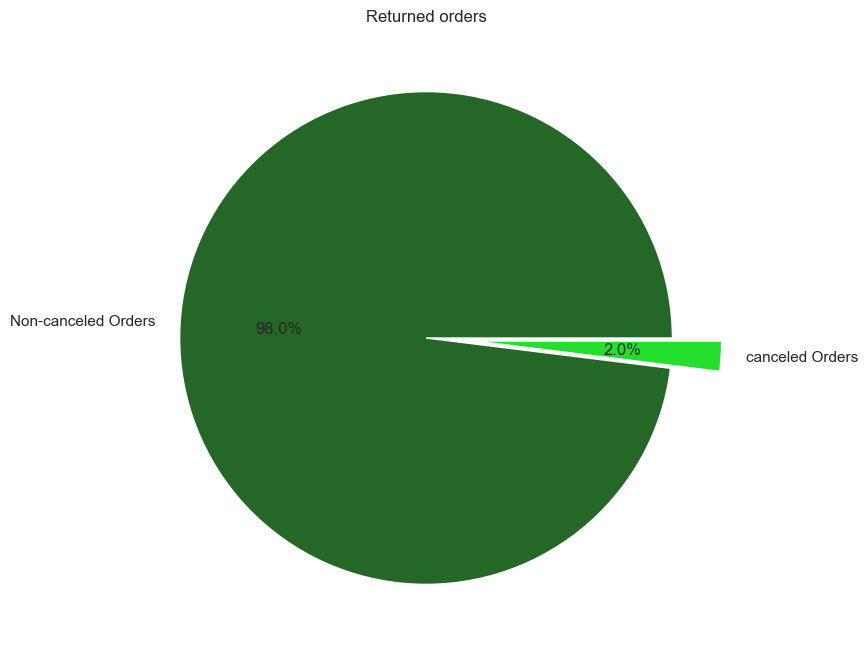

In [39]:
# What percentage of orders are returns (canceled invoices)?

values = df['canceled'].value_counts()

plt.pie(values, labels=['Non-canceled Orders','canceled Orders'],
        colors = ["#246727","#24df2d"],
        autopct='%1.1f%%', explode = [0, 0.2])
plt.title("Returned orders")
plt.show();

`2%` of orders are canceled.

In [40]:
# Are certain products or countries more prone to returns?

# Percentage of returns for each product (quality indicator)
total_qty = df.groupby('stock_code')['abs_quantity'].sum()
returned_qty = df.groupby('stock_code')['quantity'].apply(lambda x: abs(x[x < 0].sum()))
product_return_rate = (100*returned_qty / total_qty).fillna(0).rename('ProductReturnRate').round(2)
product_return_rate

stock_code
10002           13.30
10080            0.00
10109           50.00
10120           94.88
10125            0.00
                ...  
gift_0001_60     0.00
gift_0001_70     0.00
gift_0001_80     7.14
gift_0001_90     0.00
m                0.00
Name: ProductReturnRate, Length: 4631, dtype: float64

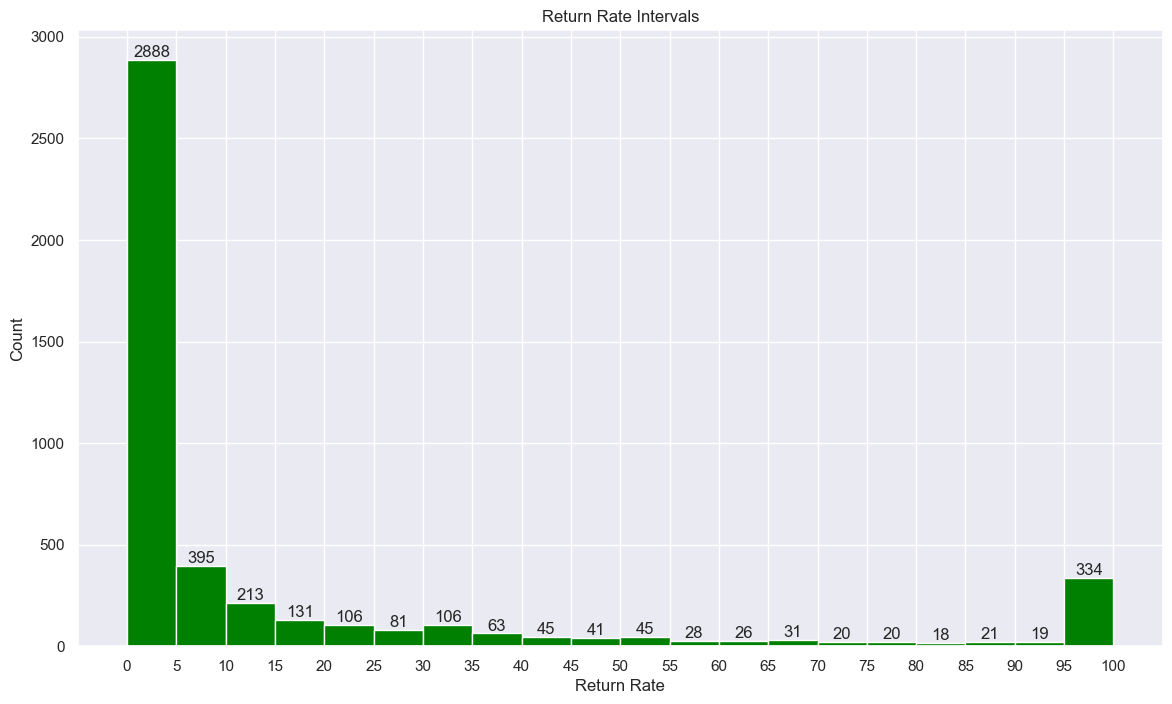

In [41]:
counts, bins, patches = plt.hist(product_return_rate, bins=20,color='green')
plt.bar_label(patches, labels=[int(c) for c in counts])
plt.xticks(bins)
plt.title('Return Rate Intervals')
plt.xlabel('Return Rate')
plt.ylabel('Count')
plt.show()

`334` products have a return probability of 95% or higher.

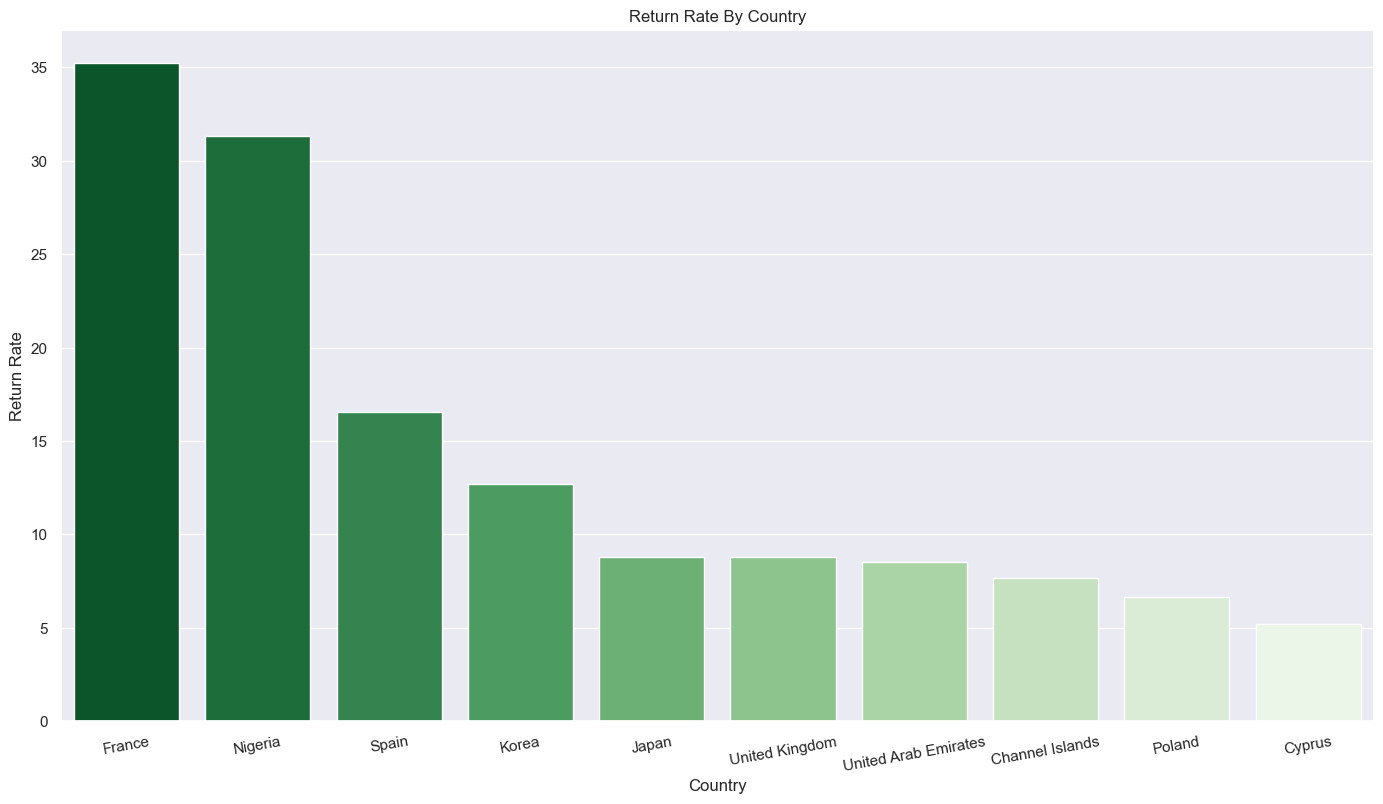

In [42]:
# for countries

total_qty = df.groupby('country')['abs_quantity'].sum()
returned_qty = df.groupby('country')['quantity'].apply(lambda x: abs(x[x < 0].sum()))
country_return_rate = (100*returned_qty / total_qty).fillna(0).rename('countryReturnRate').round(2)

df0 = country_return_rate.nlargest(n=10)
sns.barplot(data=df0,
            palette='Greens_r')
plt.xticks(rotation=10)
plt.tight_layout()
plt.title('Return Rate By Country')
plt.xlabel('Country')
plt.ylabel('Return Rate')
plt.show();

`France` and `Nigeria` show the highest return tendencies, with return rates exceeding `30%`.

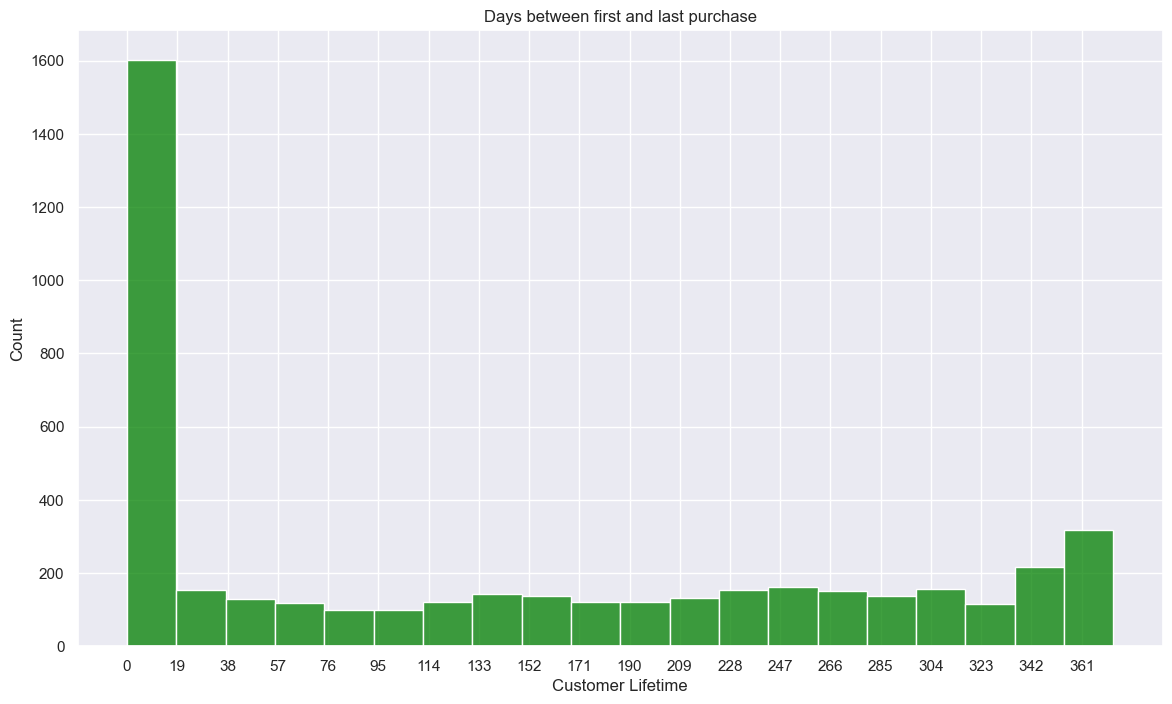

In [43]:
# Customer Lifetime (days between first and last purchase)

cust_first = df.groupby('customer_id')['invoice_date'].min().rename('first_purchase')
cust_last = df.groupby('customer_id')['invoice_date'].max().rename('last_purchase')
cust_lifetime = (cust_last - cust_first).dt.days.rename('cust_lifetime')
if 'cust_lifetime' not in df.columns: 
    df = df.merge(cust_lifetime, on='customer_id', how='left')

sns.histplot(cust_lifetime, color='green', bins=20)
plt.xticks(np.arange(0, 380, 19))
plt.title('Days between first and last purchase')
plt.xlabel('Customer Lifetime')
plt.ylabel('Count')
plt.show();

More than 1,600 customers have a purchase interval between 1 and 20 days from their first to their last transaction.


Lower bound: -2.6496569468267577, Upper bound: 8.273064608347626


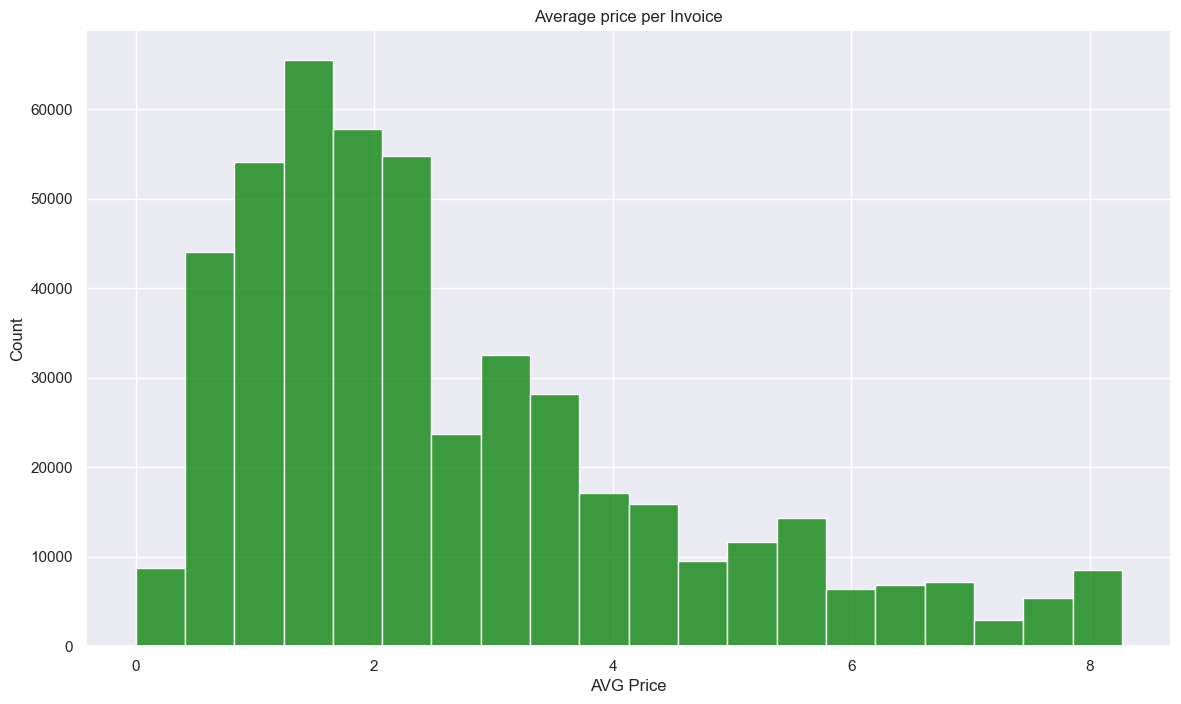

In [44]:
# Average price per Invoice

avg_price = df.groupby('stock_code')['price'].mean().rename('avg_price')
if 'avg_price' not in df.columns: 
    df = df.merge(avg_price, on='stock_code')

#removing some outliers to plot 'avg_price'
q1 = df['avg_price'].quantile(0.25)
q3 = df['avg_price'].quantile(0.75)
IQR = q3 - q1
lower_bound = q1 - 1.5*IQR
upper_bound = q3 + 1.5*IQR
print(f'Lower bound: {lower_bound}, Upper bound: {upper_bound}')

df0 = pd.DataFrame(df[df['avg_price']<=upper_bound]) 
sns.histplot(df0,x='avg_price', color='green',bins=20)
plt.title('Average price per Invoice')
plt.xlabel('AVG Price')
plt.ylabel('Count')
plt.show();

Most products have an average price between 0.20 and 2.10 USD.


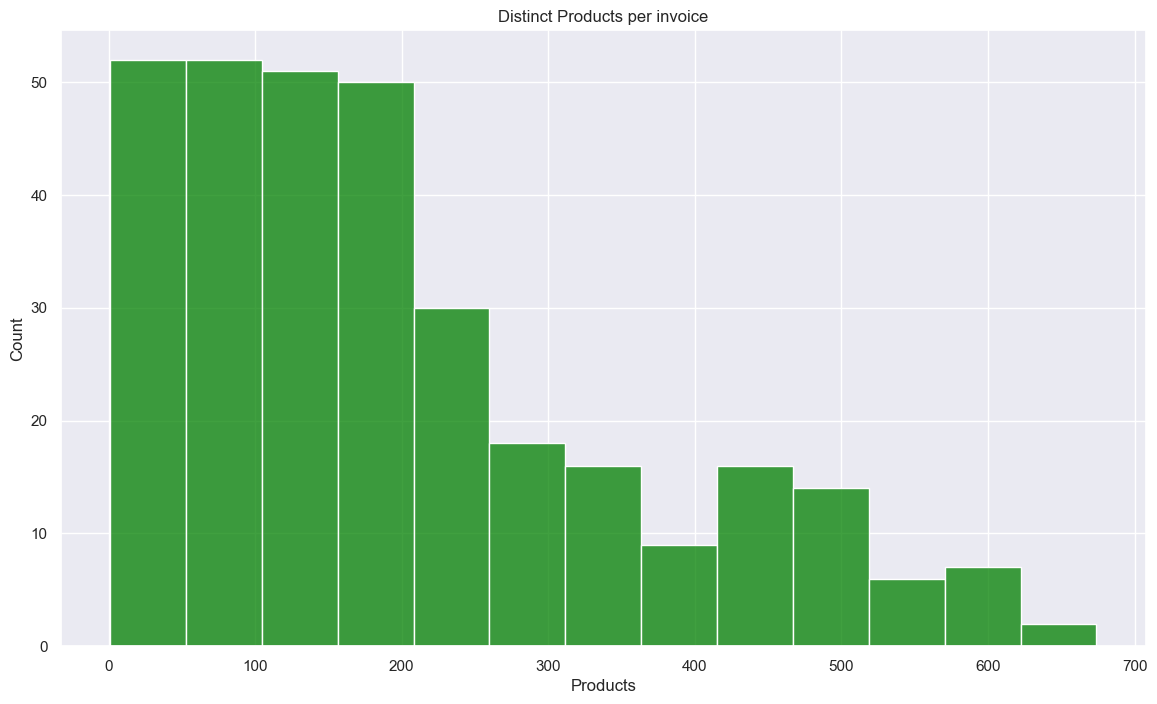

In [45]:
# Distinct Products per invoice

distinct_products = df.groupby('invoice')['stock_code'].nunique().rename('distinct_products')
if 'distinct_products' not in df.columns: 
    df = df.merge(distinct_products, on='invoice')

df0 = pd.DataFrame(distinct_products.value_counts())
sns.histplot(df0,x='distinct_products', color='green')
plt.title('Distinct Products per invoice')
plt.xlabel('Products')
plt.ylabel('Count')
plt.show();

The distribution shows that most invoices include 1–200 distinct products, with higher counts becoming increasingly rare.

### <span style='color:#3ae043'>**Correlation**</span>

In [46]:
df.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'price', 'customer_id', 'country', 'total_spend', 'canceled',
       'abs_quantity', 'week_days', 'month', 'year', 'hour_of_day', 'quarter',
       'yearmonth', 'yearWeek', 'avg_basketsize', 'avg_basketvalue',
       'num_invoices', 'revenue', 'cust_lifetime', 'avg_price',
       'distinct_products'],
      dtype='object')

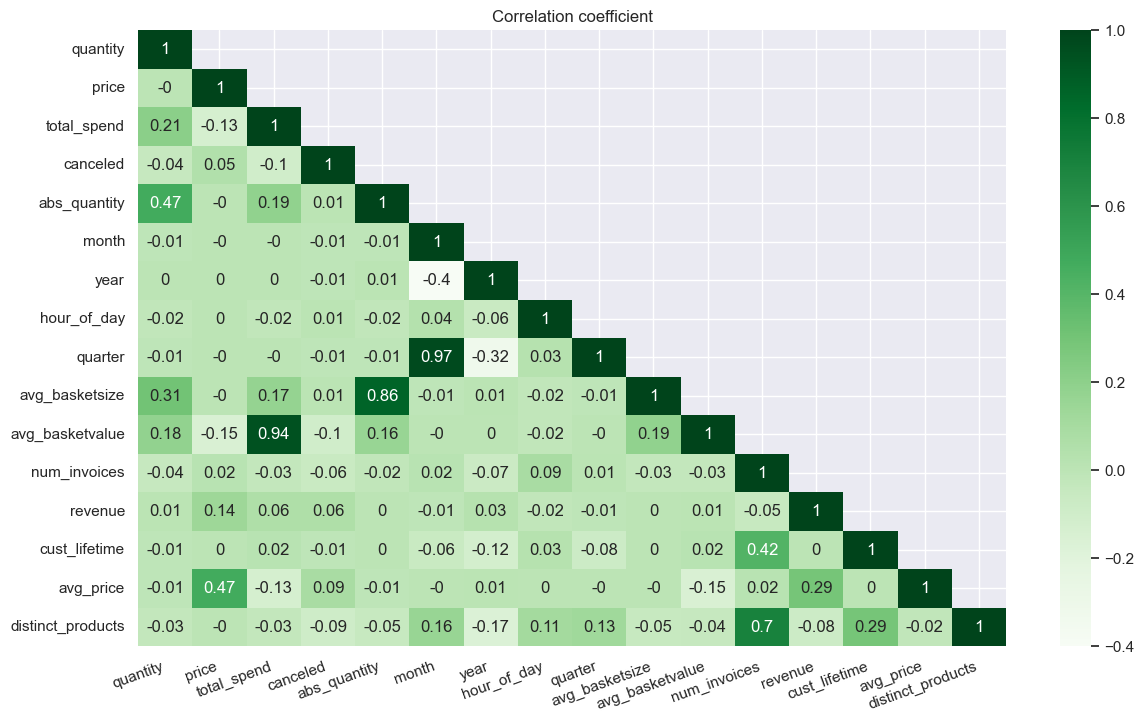

In [47]:
df0 = df.select_dtypes(include='number').corr().round(2)

sns.heatmap(df0,annot=True,cmap='Greens',
            mask = np.triu(np.ones_like(df0, dtype=bool), k=1),)
plt.title('Correlation coefficient')
plt.xticks(rotation=20, ha='right')
plt.show();

Most variables show weak or negligible correlations, indicating that customer behavior is diverse and not strongly driven by single features.  

`avg_basketsize` and `abs_quantity` show a very strong positive correlation (~0.86), which is expected because buying more items increases the basket size.  

`avg_basketvalue` and `total_spend` have an extremely strong correlation (~0.94), confirming that invoices with higher spending naturally drive `total revenue`.  

`quarter` and `month` show a very strong correlation (~0.97), reflecting seasonal structure in the data.  

cust_lifetime has only weak correlations with financial metrics, suggesting that how long a customer stays does not directly predict how much they spend.  

distinct_products and `revenue` show a moderately strong correlation (~0.70), meaning customers who buy a wider variety of products tend to generate more `revenue`.  

No harmful multicollinearity is present except within expected feature pairs (e.g., `month` vs `quarter`, `abs_quantity` vs `avg_basketsize`, `total_spend` vs `avg_basketvalue`).  

In [48]:
# Export DataFrame to a CSV file
df.to_csv('online_retail_II_processed.csv')

# <span style='color:#2e7d32'>**Key Insights and Findings**</span>

### Key Business Metrics

* Total revenue reached **10,271,762.66**, with **−629,808.65** lost due to returns (~**6.1%**).
* A total of **5,992,597 items** were sold to **4,384 customers**.
* Order cancellations remain low at around **2%**.
* **Q4** generated the highest sales.


### Customer Insights

* The top spending customers are **18102, 14646, and 14156**.
* Customer **14911** stands out with **260+ invoices**, far above the average.
* Over **1,600 customers** completed their purchase journey within **1–20 days**.
* The **United Kingdom** shows the highest overall customer spending.

**What we suggest**

* We should strengthen loyalty strategies for high-value and high-frequency customers.
* We can improve retention by engaging customers shortly after their first purchase.
* The UK market deserves priority in customer experience and growth efforts.


### Product Performance

* Best-selling products by volume: **21212, 85123A, 84077**.
* Top revenue-generating products: **M, 22423, 85123A**.
* Most returned products: **84016, 20852, 22126**.
* High sales volume is not tied strictly to high or low prices.
* Most products are priced between **0.20 and 2.10 USD**.
* Most invoices include **1–200 distinct products**.

**What we suggest**

* We should investigate high-return products to address quality or expectation gaps.
* High-revenue products can be leveraged for bundling and cross-selling.
* Pricing strategies should focus on value and turnover rather than premium pricing.

### Returns & Risk Patterns

* **334 products** show a return probability of **95% or higher**.
* **France and Nigeria** exhibit the highest return rates (above **30%**).

**What we suggest**

* We should flag and closely monitor high-risk products.
* Country-specific return behaviors need targeted policies and logistics review.


### Geographic & Time Trends

* Top revenue countries: **UK, EIRE, Netherlands, Germany, France**.
* Sales trend rises in the **first half of the year** and declines in the second.
* Best sales months: **November, September, December, October**.
* Best sales days: **Thursday, Tuesday, Monday**.
* Peak sales hour is **12:00 PM**, with strong activity from **10:00 AM to 3:00 PM**.

**What we suggest**

* We should align campaigns and inventory planning with peak months and hours.
* Promotions during weaker periods can help smooth seasonal declines.
